In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import os

In [3]:
PATH =  os.getcwd()

In [4]:
%run -i code/utils.py

# 1. Initialization

In [5]:
# Prompts user for FDS and fds2ascii executable paths & email to send notifcation
#fds_bin = input('File path to FDS executable: ')
#fds2ascii = input('File path to fds2ascii utility in FDS: ')
fds_bin = '/home1/02410/lvalera/fds/Build/impi_intel_linux_64/fds_impi_intel_linux_64'          # Stampede2/FRONTERA
fds2ascii = '/home1/02410/lvalera/FDS/FDS6/bin/fds2ascii'               # Stampede2/FRONTERA

#fds_bin = '/home/leobardovalera/FDS/FDS6/bin/fds'             # Local
#fds2ascii = '/home/leobardovalera/FDS/FDS6/bin/fds2ascii'     # Local

## 1.1 Initial Region of Interest

In [6]:
# Reads in elevation file to extract region information
name_of_file = f'{PATH}/data/Elevations_Files/gatlinburg_res_1x1.elv'
Mst_original = pd.read_csv(name_of_file )
Image_name   = f"{PATH}/data/Regions_Images/Gatlinburg_texted.png"

In [7]:
# Global Coordinates
North = 1000
South = 0
East  = 1000
West  = 0
# Coordinates of the Region's Border 
Min_x = 360      
Max_x = 700

Min_y = 200
Max_y = 700

Mst   = Mst_original.copy()
Mst = Mst[(Mst.x >= Min_x) 
        & (Mst.x <= Max_x) 
        & (Mst.y >= Min_y) 
        & (Mst.y <= Max_y)]

In [8]:
# Defines the Resolution of the Meshes and the obstacles (in Meters)
R = 2                                   # Resolution of Cells
Mst = Mst[(Mst.x%R==0) & (Mst.y%R==0)]  # Filters data 
Ro = 2    # Resolution of Obstacles

# Radius of the fire from the center
fire_radius   = 100

In [9]:
# Defines range of elevation
Min_z = 380
Max_z = 620
Regiones = [Min_x,Max_x,Min_y,Max_y,Min_z,Max_z]

## 1.2 Input FDS File Parameters

In [10]:
# Index for regions that we are simulating
num_region = 1

In [11]:
# Set time interval
T_begin    = 0.0
DTT        = 480.0
T_end      = T_begin + DTT
DT         = 0.1

# Set Number of meshes in x, y, z directions
Nmx        = 2     
Nmy        = 2    
Nmz        = 4

PC         = 1         # Predictor-Corrector Status Flag
Location   = [608,260] # Initial Location of the fire
#Child      = f"Region{num_region}" # Start of Sequential Domain Decomposition
Child      = f"Whole"

HRRPUA     = 3500      # Heat Release Rate (HRR)
rampa_time = 10       # Time that the fire ramp lasts

UVW_Timer  = 0
DT_UVW_Timer = DTT
UVW_Timer  =  UVW_Timer + DT_UVW_Timer      # Time


# File name conventions
foldername = f'Gatlinburg_R2'
filename   = f'{Child}.fds'

# Heat Release Rate (HRR) Minimum
#hrr_threshold = Ro*Ro*Ro

# Defining the dataframe with the HRR information
Hrr = Mst[(Mst['x'] <= Location[0]+2*Ro) & (Mst['x'] >= Location[0]-2*Ro) & (Mst['y'] <= Location[1]+2*Ro) & (Mst['y'] >= Location[1]-2*Ro)]
Hrr = Hrr[[Hrr.columns[0],Hrr.columns[1]]]
Hrr['hrr'] = HRRPUA

if not path.exists(f"{PATH}/simulations/{foldername}"):
    os.mkdir(f"{PATH}/simulations/{foldername}")

if not path.exists(f"{PATH}/simulations/{foldername}/{Child}"):
    os.mkdir(f"{PATH}/simulations/{foldername}/{Child}")

Hrr.to_csv(f'{PATH}/simulations/{foldername}/{Child}/Hrr_{Child}.csv', index=False)
# Function to write input FDS file with parameter specified above

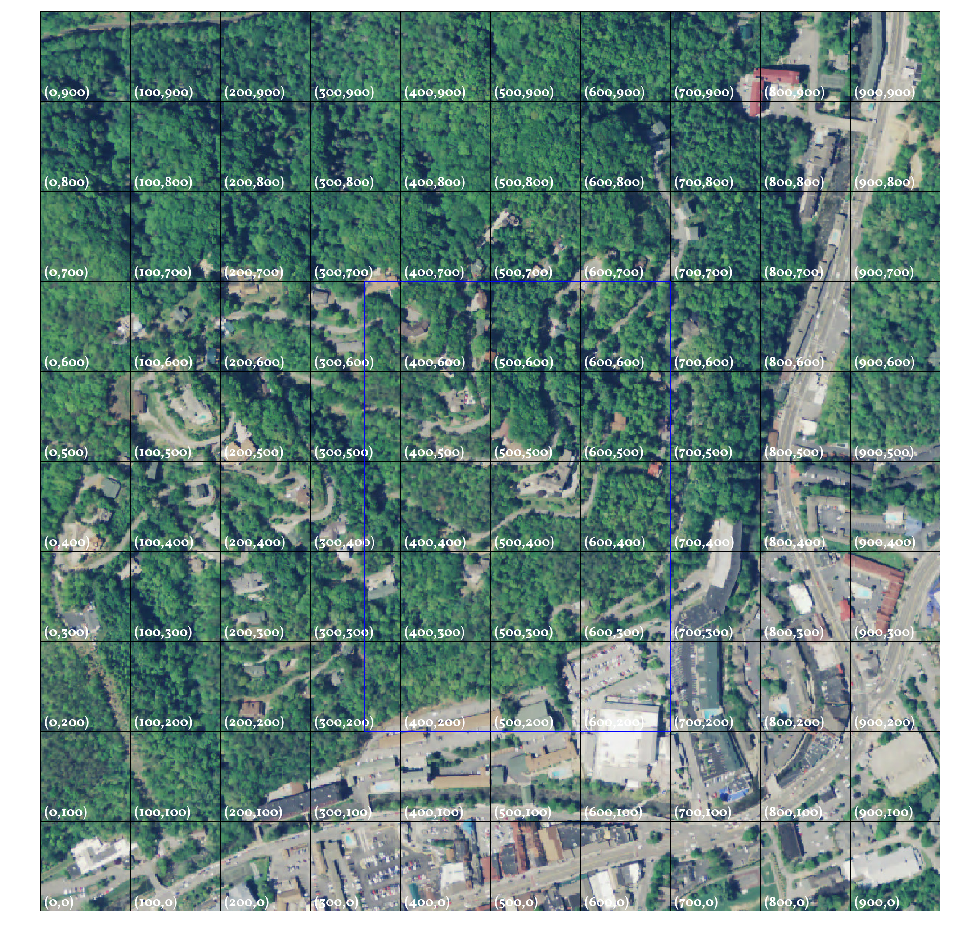

In [12]:
write_fds_file(T_begin, T_end, DT, PC, Nmx, Nmy, Nmz, Hrr, Child)

## 1.3 Sets Folders

In [13]:
FDS_FOLDER = f"simulations/{foldername}/{Child}" # Location of input FDS file

os.chdir(f'{PATH}/{FDS_FOLDER}')      # Changes directory to run the input FDS file location

## 1.4 Runs FDS

In [14]:
# User decides to run as a job on a job scheduler or directly through mpiexec command
#job_type = input("Are you running with a job scheduler? \nIf so, is it LSF or Slurm?\nIf not, you do not have to specify. ")
job_type =''

In [15]:
# Sets variables to use in job scripts/commands
num_nodes = 1             # Number of compute nodes to run job on
max_time = '3:00'         # Max time needed to run job (d-hh:mm:ss)
number_of_process = 16     # Number of processes(cores) needed to run the created meshes
omp_threads = 4           # Sets OpenMP Threads per process
jobName = f'FDS_{Child}'

In [16]:
# Options: LSF, Slurm, or direct command (mpiexec)
if job_type=="LSF" or job_type=="Lsf" or job_type=='lsf':
    USER = os.getlogin()
    create_job_script_lsf(Child, num_nodes, max_time, omp_threads)    # Creates LSF job submission script
    os.system(f'bsub < job_{Child}.bsub') # Submits job script to the LSF job scheduler
    
    job_id = Get_job_id(['bjobs', '-u', USER])
    jobs = [job_id]
    wait_on_lsf()
    
elif job_type=="SLURM" or job_type=="Slurm" or job_type=="slurm":
    USER = os.getlogin()
    
#     partition = 'skx-normal' # Can be changed to another other partition used on TACC's Stampede2
    
    create_job_script_slurm(Child, num_nodes, max_time, omp_threads)  # Creates Slurm job submission script
    os.system(f'sbatch job_{Child}.sh')   # Submits job script to the Slurm job Scheduler
    
    job_id - Get_job_id(['squeue', '-u', USER])
    jobs = [job_id]
    wait_on_slurm()
    
else: 
    os.environ['OMP_NUM_THREADS'] = f'{omp_threads}'                  # Sets OpenMP Threads to 4
    os.system(f"mpiexec -n {number_of_process} {fds_bin} {filename}") # Runs FDS using 'mpiexec' command

# 2 Checkpoint Data Extraction

## 2.1 Parses plot3d files

In [17]:
Run_Region = False

UVW_Timer  =  UVW_Timer + DT_UVW_Timer      # Time

while(Run_Region):
    quantity     = f"hrrpuv"
    first        = 1
    step         = 1
    meshes       = Nmx*Nmy*Nmz
    t_start      = T_end
    t_end        = T_end
    file         = "fds2ascii.txt"
    
    if (num_region>=2):
        hrrpuv = reading_slide(f"{Child}_cat",quantity,first,step,meshes,'./',t_start,t_end,file)
    else:
        hrrpuv = reading_slide(f"{Child}",quantity,first,step,meshes,'./',t_start,t_end,file)
    # Removing the repeated values
    # The values are repeated on the border of the meshes, so we need to remove the duplicated ones 
    hrrpuv = hrrpuv.drop_duplicates(subset = ['x', 'y','z'],keep = 'first').reset_index(drop = True)
    
    # Dropping zero values
    hrrpuv = hrrpuv[hrrpuv['hrr']>0].reset_index(drop = True) 
    hrrpuv['hrr'].to_csv(f"hrrpuv_{Child}_ini.csv",index=False)
    # Taking into account the radiation fraction
    #file1 = open(f'{Child}_hrr.csv', 'r') 
    #Lines = file1.readlines() 
    #total_hrr_region1 = Lines[-1].split(',')[1]
    #radiac_fact =  float(total_hrr_region1)/(Ro*Ro*Ro*hrrpuv['hrr'].sum())
    #hrrpuv['hrr'] = radiac_fact*hrrpuv['hrr'] 
    
    # Creating the Input data for the next region
    init_file = f'{Child}.ini'
    hrrpuv = setting_initialization(hrrpuv,Ro,init_file)
    
    minimo_x = hrrpuv['x'].min()
    maximo_x = hrrpuv['x'].max()
  
    minimo_y = hrrpuv['y'].min()
    maximo_y = hrrpuv['y'].max()

    # Defining the center of the location of the fire

    if (math.isnan(minimo_x) or math.isnan(maximo_x) or math.isnan(minimo_y) or math.isnan(maximo_y)):
        break
    center_x = math.floor((minimo_x+maximo_x)/2)
    center_y = math.floor((minimo_y+maximo_y)/2)
    
    center_x = center_x - (center_x%Ro)
    center_y = center_y - (center_y%Ro)
    
    if ((center_x < West)  or (center_x > East) or (center_y < South) or (center_y > North)):
        break
    
    # Update Region Number to next one, if needed
    num_region = num_region + 1
    
    print(minimo_x)
    print(maximo_x)
    print(minimo_y)
    print(maximo_y)
    Min_x = int(input('Input lower bound of x variable: '))
    Max_x = int(input('Input upper bound of x variable: '))
    Min_y = int(input('Input lower bound of y variable: '))
    Max_y = int(input('Input upper bound of y variable: '))
    DTT = float(input('How long would you like to simulate in this region: '))
    
    Mst   = Mst_original.copy()

    Mst = Mst[(Mst.x >= Min_x) 
        & (Mst.x <= Max_x) 
        & (Mst.y >= Min_y) 
        & (Mst.y <= Max_y)]
    # Range of elevation
    # Defines range of elevation
    Min_z = 380
    Max_z = 620

    Regiones.append([Min_x,Max_x,Min_y,Max_y,Min_z,Max_z])
    if(Hrr['hrr'].sum()==0):
        break
    
    if (Hrr.shape[0] < 1):
        break
    # Repeat Steps 1.2 - 3 (Loop)

    # Defines input variables for the next region (with respect to the previous FDS run)
    T_begin = T_end
    T_end   = T_begin+DTT
    Child_pr= Child
    Child   = f"Region{num_region}"
    filename   = f'{Child}.fds'
    
    if not path.exists(f"{PATH}/simulations/{foldername}/{Child}"):
        os.mkdir(f"{PATH}/simulations/{foldername}/{Child}")
    
    FDS_FOLDER = f"simulations/{foldername}/{Child}" # Location of input FDS fil
    os.chdir(f'{PATH}/{FDS_FOLDER}')      # Changes directory to run the input FDS file location
    
    restart_fds_file(T_begin, T_end, DT, PC, Nmx, Nmy, Nmz,Child)
    
    # Clear the list of jobids
    if 'jobs' in locals():
        jobs.clear()

    # Options: LSF, Slurm, or direct command (mpiexec)
    if job_type=="LSF" or job_type=="Lsf" or job_type=='lsf':
        create_job_script_lsf(Child, num_nodes, max_time, omp_threads)    # Creates LSF job submission script
        os.system(f'bsub < job_{Child}.bsub') # Submits job script to the LSF job scheduler

        job_id = Get_job_id(['bjobs', '-u', USER])
        #job_id = input("Enter Job ID just started: ") # Gets the job id & waits for it to finish to run the rest of the notebook
        jobs = [job_id]
        wait_on_lsf()
    elif job_type=="SLURM" or job_type=="Slurm" or job_type=="slurm":
        create_job_script_slurm(Child, num_nodes, max_time, omp_threads)  # Creates Slurm job submission script
        os.system(f'sbatch job_{Child}.sh')   # Submits job script to the Slurm job Scheduler

        job_id = input("Enter Job ID just started: ") # Gets the job id & waits for it to finish to run the rest of the notebook
        jobs = [job_id]
        wait_on_slurm()
    else: 
        os.environ['OMP_NUM_THREADS'] = f'{omp_threads}'                  # Sets OpenMP Threads to 4
        os.system(f"mpiexec -n {number_of_process} {fds_bin} {filename}") # Runs FDS using 'mpiexec' command
    

In [18]:
Regiones

[360, 700, 200, 700, 380, 620]